### Example 15 - Modeling Orders and Trades

As described in the text, our market making simulation relies on random order and trade generators.  The extent to which our simulator emulates realistic trading depends on how well our random event generators reflect actual market behavior.  We'll build our generators based on statistical properties of historical orders and trades.  From historical order book snapshots, we can model the arrival rate, side, size and price of orders as they arrive.  Likewise, we can infer or estimate trades \(as described in Example 4\) to model arrival rate, side and size of trades.  

As described in the text, we'll need to create four event generators:

1. **New Order**: an event with properties: arrival offset, side, duration, volume, minimum volume, "top of book", and price offset.
2. **Change Order**: an event with properites: arrival offset, and side.
3. **Cancel Order**: an event with properties: arrival offset, and side.
4. **Trade**: an event with properties: arrival offset, side, and volume.

For simplicity, our generators will be constructed for a single asset type using a single day of historic data.  A more realistic simulation would, of course, construct generators for all assets being traded over multiple days of historic data.

In [1]:
# Standard imports
import pandas as pd
import numpy as np
from pandas import DataFrame, Series
import matplotlib.pyplot as plt
import datetime
import scipy.interpolate
import numpy.random
%matplotlib inline
# EveKit imports
from evekit.reference import Client
from evekit.util import convert_raw_time

In [2]:
# As in previous examples, we'll consider opportunities in The Forge at the busiest station in Jita.
# We've selected a specific station because we intend to model market making which buys and sells
# from a single station.  A more general model would not be constrained to a single station.
#
# For this example, we'll build a trade model for Tritanium (type ID 34)
#
sde_client = Client.SDE.get()
region_query = "{values: ['The Forge']}"
station_query = "{values: ['Jita IV - Moon 4 - Caldari Navy Assembly Plant']}"
region_id = sde_client.Map.getRegions(regionName=region_query).result()[0][0]['regionID']
station_id = sde_client.Station.getStations(stationName=station_query).result()[0][0]['stationID']
compute_date = datetime.datetime(2017, 1, 10)
model_type = 34 # Type ID for Tritanium
print("Using region_id=%d, station_id=%d, type_id=%d at %s" % (region_id, station_id, model_type, str(compute_date)))

Using region_id=10000002, station_id=60003760, type_id=34 at 2017-01-10 00:00:00


In [3]:
# Retrieve type information for our type
market_type_map = {}
type_query = "{values:[34]}"
for x in Client.SDE.load_complete(sde_client.Inventory.getTypes, typeID=type_query):
    market_type_map[x['typeID']] = x
len(market_type_map.keys())

1

In [4]:
# In order to build the trade portion of our fill simulator we need to infer trades.
# We'll use the volume threshold trade infer function we developed in Example 4 which will
# require market history.  We'll use thirty days prior to our target date which we load here.
from evekit.marketdata import MarketHistory
date_range = pd.date_range(compute_date - datetime.timedelta(days=30), compute_date - datetime.timedelta(days=1))
market_history = MarketHistory.get_data_frame(dates=date_range, types=market_type_map.keys(), regions=[region_id], 
                                              config=dict(local_storage=".", tree=True, skip_missing=True, verbose=True))

Retrieving 2016-12-11 00:00:00...done
Retrieving 2016-12-12 00:00:00...done
Retrieving 2016-12-13 00:00:00...done
Retrieving 2016-12-14 00:00:00...done
Retrieving 2016-12-15 00:00:00...done
Retrieving 2016-12-16 00:00:00...done
Retrieving 2016-12-17 00:00:00...done
Retrieving 2016-12-18 00:00:00...done
Retrieving 2016-12-19 00:00:00...done
Retrieving 2016-12-20 00:00:00...done
Retrieving 2016-12-21 00:00:00...done
Retrieving 2016-12-22 00:00:00...done
Retrieving 2016-12-23 00:00:00...done
Retrieving 2016-12-24 00:00:00...done
Retrieving 2016-12-25 00:00:00...done
Retrieving 2016-12-26 00:00:00...done
Retrieving 2016-12-27 00:00:00...done
Retrieving 2016-12-28 00:00:00...done
Retrieving 2016-12-29 00:00:00...done
Retrieving 2016-12-30 00:00:00...done
Retrieving 2016-12-31 00:00:00...done
Retrieving 2017-01-01 00:00:00...done
Retrieving 2017-01-02 00:00:00...done
Retrieving 2017-01-03 00:00:00...done
Retrieving 2017-01-04 00:00:00...done
Retrieving 2017-01-05 00:00:00...done
Retrieving 2

In [5]:
# Finally, we need the order book for our sample day.
from evekit.marketdata import OrderBook
order_book = OrderBook.get_data_frame(dates=[compute_date], types=market_type_map.keys(), regions=[region_id], 
                                      config=dict(local_storage=".", tree=True, skip_missing=True, 
                                                  fill_gaps=True, verbose=True))

Retrieving 2017-01-10 00:00:00...done


In [6]:
# Since we're only considering market making, we can filter the book down to
# just our target station.
order_book_local = order_book[order_book.location_id == station_id]

In [7]:
# In preparation for trade inference, we need to commpute a volume threshold series for each type
# which will help us distinguish between large orders and cancels.
volume_thresh_multiplier = 0.04
volume_thresh_map = {}
for next_type in market_history.groupby(market_history.type_id):
    group_id = next_type[0]
    group_df = next_type[1]
    volume_thresh_map[group_id] = group_df.volume.rolling(window=5, center=False).mean() * volume_thresh_multiplier

The essence of our trading model is that it is based on historical observations of orders and trades.  To that end, we'll need to extract and track the arrival of orders and trades for each asset type across all book snapshots.  We'll start with the first snapshot of the day as a given and track all changes after that.  For this example, we're only considering a single day of history.  In reality, we'll need to extract historic observations over multiple days and build our trade observations from that combined data.  Note that we don't bother recording price information for orders or trades as this is likely to change day to day and is not relevant for our simulation needs.  We do, however, extract a reference price and spread from the first order book snapshot.  These values are used to help prime simulated books with reasonable starting values.

In [8]:
# The following function collects order book changes starting from the first snapshot for a given 
# asset type.  As part of this pricess, we also need to infer trades so that we can distinguish
# complete fills from cancels.  We use the same technique for trade inference that we've used in
# previous examples.
#
# The result of this function will be a tuple (ref_price, ref_spread, order_series, trade_series) 
# where ref_price is the reference price chosen for the day; ref_spread is the reference difference
# between the best bid and ask for the chosen day; order_series is the series of orders 
# arriving, changed or canceled from the book; and, trade_series is the series of trades 
# inferred from the book.
#
def collect_book_changes(type_id, dt, order_book, volume_threshold_map):
    order_series = []
    trade_series = []
    by_type = order_book[order_book.type_id == type_id]
    vol_limit = volume_threshold_map[type_id][dt - datetime.timedelta(days=1)]
    #
    # Convenience function to copy an order
    #
    def copy_order(order):
        return dict(buy=order['buy'], duration=order['duration'], issued=order['issued'], location_id=order['location_id'],
                    min_volume=order['min_volume'], order_id=order['order_id'], region_id=order['region_id'], 
                    type_id=order['type_id'], volume=order['volume'], volume_entered=order['volume_entered'])
    #
    # Determine a reference price from the spread mid-point in the first snapshot.  The reference point can be
    # arbitrary as long as we are consistent.
    #
    first_snap = by_type.ix[by_type.index[0]]
    best_bid = first_snap[first_snap.buy == True]
    best_ask = first_snap[first_snap.buy == False]
    ref_price = 0
    ref_spread = 0
    if len(best_ask) > 0 and len(best_bid) > 0:
        ref_price = (best_ask.ix[0].price + best_bid.ix[0].price) / 2
        ref_spread = best_ask.ix[0].price - best_bid.ix[0].price
    elif len(best_ask) > 0:
        ref_price = best_ask.ix[0].price / 2
        ref_spread = ref_price * 0.1
    elif len(best_bid) > 0:
        ref_price = best_bid.ix[0].price
        ref_spread = ref_price * 0.1
    #
    # Iterate over consecutive book snapshots looking for order book changes.
    #
    snap_list = list(by_type.groupby(by_type.index))
    snap_pairs = zip(snap_list, snap_list[1:])
    for current, next in snap_pairs:
        current_snap = current[1]
        current_time = current[0]
        next_snap = next[1]
        next_time = next[0]
        # Look for new orders added in the next snapshot
        new_id_set = set(next_snap.order_id).difference(set(current_snap.order_id))
        if len(new_id_set) > 0:
            for next_row in next_snap.iterrows():
                if next_row[1]['order_id'] in new_id_set:
                    cp_order = copy_order(next_row[1])
                    cp_order['time'] = next_time
                    cp_order['action'] = 'new'
                    # Indicate whether this order entereed at the top of the book
                    by_side = next_snap[next_snap.buy == cp_order['buy']]
                    cp_order['tob'] = by_side.ix[0]['order_id'] == cp_order['order_id']
                    order_series.append(cp_order)
        # Look for volume changes.  These are trades.
        merged = pd.merge(current_snap, next_snap, on="order_id")
        changed_orders = merged[merged.volume_x != merged.volume_y]
        for next_change in changed_orders.index:
            # Create the trade object
            next_line = changed_orders.ix[next_change]
            amount = next_line.volume_x - next_line.volume_y 
            location = next_line.location_id_x
            if next_line.buy_x and next_line.order_range_x != 'station':
                # For buy orders, we can't be certain where the trade occurred unless the buy is limited to a station
                location = None
            trade_series.append(dict(time=next_time, buy=next_line.buy_x, order_id=next_line.order_id,
                                     volume=amount, location=str(location)))
        # Now handle order price changes.
        changed_orders = merged[merged.price_x != merged.price_y]
        for next_change in changed_orders.index:
            # Create the order object
            next_line = changed_orders.ix[next_change]
            cp_order = dict(buy=next_line['buy_x'], duration=next_line['duration_x'], issued=next_line['issued_x'], 
                            location_id=next_line['location_id_x'], min_volume=next_line['min_volume_x'], 
                            order_id=next_line['order_id'], region_id=next_line['region_id_x'], 
                            type_id=next_line['type_id_x'], volume=next_line['volume_x'], 
                            volume_entered=next_line['volume_entered_x'], time=next_time, action='change')
            order_series.append(cp_order)
        # Look for removed orders.  These are either a fully filled order or a cancel.
        removed_orders = set(current_snap.order_id).difference(set(next_snap.order_id))
        for order_id in removed_orders:
            next_line = current_snap[current_snap.order_id == order_id].ix[current[0]]
            # If the volume of a removed order does not exceed the threshold, then keep it.
            if next_line.volume <= vol_limit:
                location = next_line.location_id
                if next_line.buy and next_line.order_range != 'station':
                    # See above
                    location = None
                trade_series.append(dict(time=next_time, buy=next_line.buy, order_id=next_line.order_id,
                                         volume=next_line.volume, location=str(location)))
            else:
                # Save as a canceled order
                cp_order = copy_order(next_line)
                cp_order['time'] = next_time
                cp_order['action'] = 'cancel'
                order_series.append(cp_order)
    # Return result
    return (ref_price, ref_spread, order_series, trade_series)

In [9]:
# With our book change function in hand, we're ready to extract order and trade data for Tritanium.
#
(ref_price, ref_spread, orders, trades) = collect_book_changes(model_type, compute_date, order_book_local, volume_thresh_map)

Our goal is to build a model of Tritanium which can generate a reasonable set of random orders and trades which emulate actual trading.  To do this, we'll build a number of distributions which we can sample to generate random orders and trades.  We'll start by creating a generator to produce random trades.  A trade has three characteristics we need to model:

1. A side (either buy or sell); 
2. An arrival offset (delay from current time when trade will arrive); and, 
3. A volume

One might wonder why we're not also computing a trade price.  This is because we assume trades always fill the top of the book.  Therefore, trade price is determined by existing orders: once we compute the side where the trade falls, we can compute the trade price.

(0, 100000000)

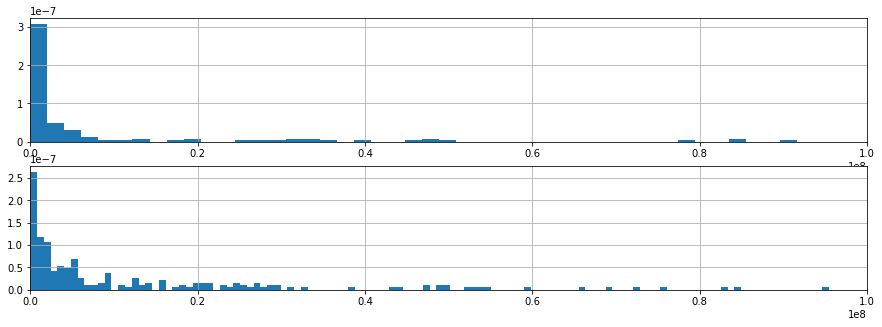

In [10]:
# We'll start by creating a generator to produce random trade volume.  We COULD try to model trade
# volume in aggregate, but in reality it's likely that sell and buy volume have different
# distributions.  We can verify our intuition by looking at the distribution of buy and sell trades
# we inferred from our sample day.
#
fig = plt.figure()
ax1 = fig.add_subplot(2, 1, 1)
pd.Series([x['volume'] for x in trades if x['buy']]).hist(ax=ax1, figsize=[15,5], normed=True, bins=1000)
ax1.set_xlim(0, 100000000)
ax2 = fig.add_subplot(2, 1, 2)
pd.Series([x['volume'] for x in trades if not x['buy']]).hist(ax=ax2, figsize=[15,5], normed=True, bins=1000)
ax2.set_xlim(0, 100000000)

There are more sell trades than buys which distorts the data, but there are also some clear differences in the distribution, especially in the tail.

How can we model the distribution of trade volume for our simulation?  Normally, we would attempt to match the shape of our distribution to a well known statistical distribution.  However, we don't have enough data to make that possible in this example.  Also, market data at this granularity \(i.e. very fine\) is notoriously difficult to map to simple distributions.  To work around this problem, we'll instead resort to a rough approximation using a distribution based on the cumulative distribution function \(CDF\) inferred from the raw sample data.  We can create a CDF using a histogram with cumulative sums across the buckets.  Taking the inverse of this CDF gives a function we can randomly sample to generate values from the 
data population.  This is a well known technique which we implement in the next cell.

In [11]:
# Create random sample generator from sample data and a random seed
#
def create_sample_generator(data, bin_count, seed):
    # Compute CDF from histogram
    counts, bins = np.histogram(data, bins=bin_count, density=True)
    cum_values = np.zeros(bins.shape)
    cum_values[1:] = np.cumsum(counts*np.diff(bins))
    # Invert the CDF to create a sample function from [0,1] to our sample domain
    inv_cdf = scipy.interpolate.interp1d(cum_values, bins)
    rnd = numpy.random.RandomState(seed)
    return lambda : int(inv_cdf(rnd.rand()))

(0, 100000000)

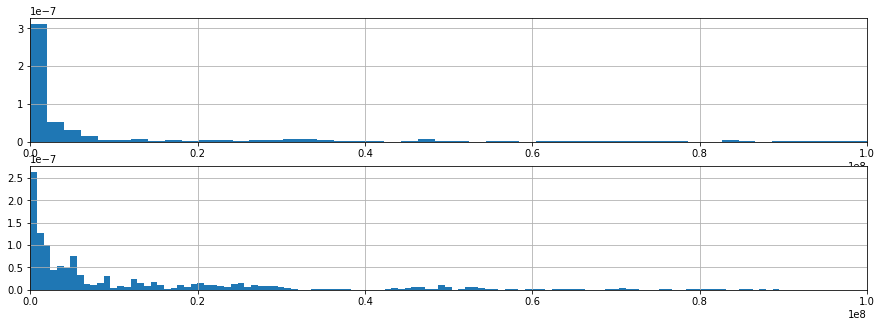

In [12]:
# With our sample generator in hand, we can now create volume generators for sell and buy trade volume.
# The following code creates these generators, then plots samples drawn from these generators.
#
buy_trade_gen = create_sample_generator([x['volume'] for x in trades if x['buy']], 1000, 1)
sell_trade_gen = create_sample_generator([x['volume'] for x in trades if not x['buy']], 1000, 1)
#
fig = plt.figure()
ax1 = fig.add_subplot(2, 1, 1)
pd.Series([buy_trade_gen() for x in range(10000)]).hist(ax=ax1, figsize=[15,5], normed=True, bins=1000)
ax1.set_xlim(0, 100000000)
ax2 = fig.add_subplot(2, 1, 2)
pd.Series([sell_trade_gen() for x in range(10000)]).hist(ax=ax2, figsize=[15,5], normed=True, bins=1000)
ax2.set_xlim(0, 100000000)

Not surprisingly, samples drawn from these generators look very similar to our plots of the raw data above.

Now let's turn to trade interarrival time.  We can use the same code from above to produce a trade interarrival generator.  There's one catch with interarrival times, however, which is that they will all be on five minute boundaries because we assign the trade time based on snapshot time.  This would make simulated interarrival time unrealistic and also easy to game in a strategy.  Therefore, we'll skew interarrival times by adding a uniformly distributed value between 0 and 300 seconds to each sample.  This will simulate a trade arriving sometime in the interval between two snapshots.  With that one small change, we're now ready to create our trade interarrival time generator in the next cell.

In [13]:
# We'll create the interarrival time generator by extracting trade times, computing their difference
# (thus creating an INTERarrival time), then randomly skewing the result as described above.
#
# Extract interarrival times, dropping the first value which will not be a diff
trade_interarrival = pd.Series([x['time'] for x in trades]).diff()[1:].apply(lambda x: x.seconds)
#
# Skew each value randomly from 0 to 300 seconds
trade_skewer = numpy.random.RandomState(1)
trade_interarrival = trade_interarrival.apply(lambda x: x + int(trade_skewer.rand() * 300))
#
# Create sample generator
trade_arrival_gen = create_sample_generator(list(trade_interarrival), 10000, 1)

Finally, we're left with trade side.  Since there are only two sides, we can construct a much simpler generator based on the ratio of buys to sells.

In [14]:
# Returns True if the next trade is a buy and False otherwise
#
def create_trade_side_generator(trades, seed):
    buy_count = len([x for x in trades if x['buy']])
    sell_count = len([x for x in trades if not x['buy']])
    buy_threshold = buy_count / (buy_count + sell_count)
    buy_gen = numpy.random.RandomState(seed)
    return lambda: True if buy_gen.rand() <= buy_threshold else False

trade_side_gen = create_trade_side_generator(trades, 1)

In [15]:
# We can put all of these pieces together to create a simulated trade generator
#
def trade_generator(side_gen, buy_vol_gen, sell_vol_gen, arrival_time_gen):
    def get_next_trade():
        next_side = side_gen()
        next_volume = max(buy_vol_gen() if next_side else sell_vol_gen(), 1)
        next_arrival = max(arrival_time_gen(), 1)
        return dict(arrival=next_arrival, buy=next_side, volume=next_volume)
    return get_next_trade

sim_trade_gen = trade_generator(trade_side_gen, buy_trade_gen, sell_trade_gen, trade_arrival_gen)

In [16]:
# Here's a sample generated trade value
sim_trade_gen()

{'arrival': 259, 'buy': False, 'volume': 20780109}

We'll turn now to constructing generators for random orders.  There are three order operations we need to simulate:

1. New order arriving
2. Order price change
3. Order cancellation

It's likely that order type \(i.e. new vs. change vs. cancel\) has an effect on the distributions which describe the properties of these orders.  Therefore, we'll model each order type separately.  We'll also make one additional simplification which is that we won't try to model order prices.  As described in the text, we'll instead price orders based on orders currently in the book, only using an explicit reference price when a side of the book is empty.  We'll explain how this affects each order type in the descriptions below.

Starting with new orders, we need to model the following properties:

* *side* - either buy or sell 
* *duration* - the number of days for which the order will be active
* *interarrival time* - the time \(in seconds\) before the next order will arrive
* *minimum volume* - minimum volume that must be transacted on each trade
* *volume* - total volume to buy or sell
* *top of book* - True if the order entered the snapshot as the new best bid or ask

As discussed above, we've omitted a property for the new order price.  Instead, we'll determine price as follows \(this is also described in the book text\):

1. If the side of the book where the order will appear is empty, then the new order is priced at a small random offset from a reference price.
2. If the order is marked "top of book", then the new order is always priced just above the current best offer on the appropriate side.
3. Otherwise, the order is placed randomly among the appropriate side with the position determined by an exponential distribution favoring the top of the book.  The price of the new order is just above the order which appears "behind" it in the book.

We'll derive a generator for each of these properties, then assemble all generators into a function which generates new random orders.


In [17]:
# Extract new order data.
#
new_orders = [x for x in orders if x['action'] == 'new']
#
# For the side generator, we can re-use our code for trades.
#
new_order_side = create_trade_side_generator(new_orders, 1)
#
# For duration, we need to constrain the values to a specific set.  We build the generator from an index
# into the allowable durations, then reverse the mapping when we generate sample values.
#
allowed_durations = [1, 3, 7, 14, 30, 90]
def create_order_duration_generator(orders, seed):
    durations = [allowed_durations.index(x['duration']) for x in new_orders if x['duration'] > 0]
    gen = create_sample_generator(durations, 1000, seed)
    return lambda: allowed_durations[gen()]

new_order_duration = create_order_duration_generator(new_orders, 1)
#
# As with trades, we need to skew interrarival time to appear randomly in the snapshot time interval.
#
new_order_interarrival_samples = pd.Series([x['time'] for x in new_orders]).diff()[1:].apply(lambda x: x.seconds)
new_order_skewer = numpy.random.RandomState(1)
new_order_interarrival_samples = new_order_interarrival_samples.apply(lambda x: x + int(new_order_skewer.rand() * 300))
new_order_interarrival = create_sample_generator(list(new_order_interarrival_samples), 10000, 1)
#
# Minimum volume and volume are straightforward.
#
new_order_min_volume = create_sample_generator([x['min_volume'] for x in new_orders], 1000, 1)
new_order_volume = create_sample_generator([x['volume'] for x in new_orders], 1000, 1)
#
# Finally, top of book is handled similar to side in that we sample uniformly across the sample count.
#
# Returns True if the next order is "top of book" and False otherwise
#
def create_top_of_book_generator(orders, seed):
    top_count = len([x for x in orders if x['tob']])
    ntop_count = len([x for x in orders if not x['tob']])
    top_threshold = top_count / (top_count + ntop_count)
    top_gen = numpy.random.RandomState(seed)
    return lambda: True if top_gen.rand() <= top_threshold else False

new_order_tob = create_top_of_book_generator(new_orders, 1)

In [18]:
# We can put all of these pieces together to create a simulated new order generator
#
def new_order_generator(side_gen, duration_gen, arrival_time_gen, min_vol_gen, vol_gen, tob_gen):
    def get_next_new_order():
        next_side = side_gen()
        next_duration = duration_gen()
        next_arrival = max(arrival_time_gen(), 1)
        next_min_vol = max(min_vol_gen(), 1)
        next_vol = max(vol_gen(), 1)
        next_tob = tob_gen()
        return dict(arrival=next_arrival, buy=next_side, duration=next_duration, min_volume=next_min_vol,
                    volume=next_vol, tob=next_tob)
    return get_next_new_order

sim_new_order_gen = new_order_generator(new_order_side, new_order_duration, new_order_interarrival, 
                                        new_order_min_volume, new_order_volume, new_order_tob)

Order changes and cancels will have similar properties:

* *side* - the side of the book the order will affect
* *interarrival time* - the time in seconds until the next instance of this event type

For change orders, we once again omit specific price targets and instead handle these orders as follows:

1. If the side where the change will occur is empty, then the change order is silently discarded.
2. Otherwise, an order is selected randomly using an exponential distribution which favors the top of the book.  The selected order is immediately repriced to the top of the book on the appropriate side.

Our handling of change orders is based on the intuition that, in an active market, most order changes will be for the purpose of capturing the top of the book.  Therefore, most changed orders should become the new best bid or ask.

For cancel orders, price is not relevant.  Instead, as described in the text, we'll randomly select an order to remove where the selection is exponentially distributed favoring the bottom of the appropriate side of the book.  Our intuition here is that in an active market, cancels are more likely to occur on orders well away from the top of book \(i.e. orders very unlikely to fill soon\).

In the next few cells, we'll derive generators for these properties, then assemble the generators into functions which generate random change and cancel orders.

In [19]:
# Extract change and cancel order data
#
change_orders = [x for x in orders if x['action'] == 'change']
cancel_orders = [x for x in orders if x['action'] == 'cancel']

# We can use our side generator from above for order side.
#
change_order_side = create_trade_side_generator(change_orders, 1)
cancel_order_side = create_trade_side_generator(cancel_orders, 1)

# Interarrival time is generated as before.  Both change and cancel order times need
# to be skewed because they are based on snapshot time which is constrained to five
# minute boundaries.
#
change_order_interarrival_samples = pd.Series([x['time'] for x in change_orders]).diff()[1:].apply(lambda x: x.seconds)
cancel_order_interarrival_samples = pd.Series([x['time'] for x in cancel_orders]).diff()[1:].apply(lambda x: x.seconds)
order_skewer = numpy.random.RandomState(1)
change_order_interarrival_samples = change_order_interarrival_samples.apply(lambda x: x + int(order_skewer.rand() * 300))
cancel_order_interarrival_samples = cancel_order_interarrival_samples.apply(lambda x: x + int(order_skewer.rand() * 300))
change_order_interarrival = create_sample_generator(list(change_order_interarrival_samples), 10000, 1)
cancel_order_interarrival = create_sample_generator(list(cancel_order_interarrival_samples), 10000, 1)

In [20]:
# Since change and cancel orders are so similar, we can use a generic generator function for both
#
def change_cancel_order_generator(side_gen, arrival_time_gen):
    def get_next_order():
        next_side = side_gen()
        next_arrival = max(arrival_time_gen(), 1)
        return dict(arrival=next_arrival, buy=next_side)
    return get_next_order

sim_change_order_gen = change_cancel_order_generator(change_order_side, change_order_interarrival)
sim_cancel_order_gen = change_cancel_order_generator(cancel_order_side, cancel_order_interarrival)

In [21]:
# Finally, we can test each of our new generators
print(sim_new_order_gen())
print(sim_change_order_gen())
print(sim_cancel_order_gen())

{'arrival': 572, 'buy': False, 'duration': 30, 'min_volume': 1, 'volume': 2546478, 'tob': True}
{'arrival': 6025, 'buy': True}
{'arrival': 2424, 'buy': True}


We'll use the techniques we derived in this example to create random order and trade generators in our simple market making simulator.  As discussed above, our simulator will use larger data sets for constructing random distributions of generator properties.